In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import stan
import httpstan
import nest_asyncio
nest_asyncio.apply()
import matplotlib.pyplot as plt

if torch.backends.mps.is_available():
    device = torch.device('mps')
    print('Using Apple Metal (MPS)')
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using CUDA')
else:
    device = torch.device('cpu')
    print('Using CPU')

print(f'Device: {device}')

Using Apple Metal (MPS)
Device: mps


In [2]:
print('Loading pre-trained ResNet56 for CIFAR-10...')

try:
    resnet_model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet56", pretrained=True)
    resnet_model = resnet_model.to(device)
    print('✓ ResNet56 loaded successfully')
    print(f'  Parameters: {sum(p.numel() for p in resnet_model.parameters()):,}')
except Exception as e:
    print(f'✗ Failed to load model: {e}')


Loading pre-trained ResNet56 for CIFAR-10...
✓ ResNet56 loaded successfully
  Parameters: 855,770


Using cache found in /Users/Studies/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


In [3]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=0)

print('Data loaded.')


Data loaded.


In [4]:
val_size = 5000
val_indices = torch.randperm(len(testset))[:val_size]
val_subset = torch.utils.data.Subset(testset, val_indices)
valloader = DataLoader(val_subset, batch_size=128, shuffle=False, num_workers=0)

test_indices = torch.randperm(len(testset))[val_size:]
test_subset = torch.utils.data.Subset(testset, test_indices)
testloader_final = DataLoader(test_subset, batch_size=128, shuffle=False, num_workers=0)

print(f'Validation set: {len(val_subset)} samples')
print(f'Test set: {len(test_subset)} samples')


Validation set: 5000 samples
Test set: 5000 samples


In [5]:
def get_logits_and_labels(model, dataloader, device):
    model.eval()
    logits_list = []
    labels_list = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            logits = model(inputs)
            logits_list.append(logits.cpu().numpy())
            labels_list.append(labels.cpu().numpy())
    
    return np.concatenate(logits_list), np.concatenate(labels_list)

print('Extracting logits and labels from validation set...')
logits_val, labels_val = get_logits_and_labels(resnet_model, valloader, device)

print('Extracting logits and labels from test set...')
logits_test, labels_test = get_logits_and_labels(resnet_model, testloader_final, device)

print(f'\nValidation logits shape: {logits_val.shape}')
print(f'Validation labels shape: {labels_val.shape}')
print(f'Test logits shape: {logits_test.shape}')
print(f'Test labels shape: {labels_test.shape}')


Extracting logits and labels from validation set...
Extracting logits and labels from test set...

Validation logits shape: (5000, 10)
Validation labels shape: (5000,)
Test logits shape: (5000, 10)
Test labels shape: (5000,)


In [6]:
class TemperatureScaling(nn.Module):
    def __init__(self):
        super(TemperatureScaling, self).__init__()
        self.temperature = nn.Parameter(torch.ones(1))
    
    def forward(self, logits):
        return logits / self.temperature

def calibrate_temperature_lbfgs(logits, labels, device, max_iter=50):
    logits_torch = torch.tensor(logits, device=device)
    labels_torch = torch.tensor(labels, device=device)
    
    temperature_model = TemperatureScaling().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.LBFGS([temperature_model.temperature], lr=0.01, max_iter=max_iter)
    
    def eval():
        optimizer.zero_grad()
        loss = criterion(temperature_model(logits_torch), labels_torch)
        loss.backward()
        return loss
    
    optimizer.step(eval)
    
    return temperature_model.temperature.item()

print('Running L-BFGS temperature scaling...')
calibrated_temp = calibrate_temperature_lbfgs(logits_val, labels_val, device, max_iter=1000)
print(f'Calibrated temperature: {calibrated_temp:.4f}')


Running L-BFGS temperature scaling...
Calibrated temperature: 1.7637


In [7]:
stan_model_code = """
data {
    int<lower=0> N;
    int<lower=2> K;
    matrix[N, K] logits;
    array[N] int<lower=1, upper=K> y;
    real<lower=0> prior_alpha;
    real<lower=0> prior_beta;
}
parameters {
    real<lower=0> temperature;
}
model {
    temperature ~ gamma(prior_alpha, prior_beta);
    
    for (n in 1:N) {
        vector[K] scaled_logits = logits[n]' / temperature;
        y[n] ~ categorical_logit(scaled_logits);
    }
}
"""

print('Stan model code defined.')


Stan model code defined.


In [9]:
print('='*60)
print('BAYESIAN MCMC TEMPERATURE SCALING WITH PYSTAN')
print('='*60)

prior_alpha = 4.0
prior_beta = 4.0 / calibrated_temp

stan_data = {
    'N': logits_val.shape[0],
    'K': logits_val.shape[1],
    'logits': logits_val.tolist(),
    'y': (labels_val + 1).tolist(),
    'prior_alpha': prior_alpha,
    'prior_beta': prior_beta
}

print(f'\nPrior: Gamma(α={prior_alpha:.2f}, β={prior_beta:.4f})')
print(f'Validation set size: {logits_val.shape[0]}')
print(f'Number of classes: {logits_val.shape[1]}')
print(f'\nBuilding Stan model...')

posterior = stan.build(stan_model_code, data=stan_data)

print('Sampling from posterior...')
print('This may take a few minutes...\n')

fit = posterior.sample(num_chains=4, num_samples=2000, num_warmup=1000)

print('\nSampling complete!')


BAYESIAN MCMC TEMPERATURE SCALING WITH PYSTAN

Prior: Gamma(α=4.00, β=2.2680)
Validation set size: 5000
Number of classes: 10

Building Stan model...
Building...


Building: found in cache, done.Messages from stanc:
    is provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%

Sampling from posterior...
This may take a few minutes...




Sampling:   1% (100/12000)
Sampling:   2% (200/12000)
Sampling:   2% (300/12000)
Sampling:   3% (301/12000)
Sampling:   3% (401/12000)
Sampling:   4% (501/12000)
Sampling:   5% (600/12000)
Sampling:   6% (700/12000)
Sampling:   7% (800/12000)
Sampling:   8% (900/12000)
Sampling:   8% (1000/12000)
Sampling:   9% (1100/12000)
Sampling:  10% (1200/12000)
Sampling:  12% (1400/12000)
Sampling:  12% (1500/12000)
Sampling:  13% (1600/12000)
Sampling:  14% (1700/12000)
Sampling:  15% (1800/12000)
Sampling:  16% (1900/12000)
Sampling:  17% (2000/12000)
Sampling:  18% (2200/12000)
Sampling:  19% (2300/12000)
Sampling:  21% (2500/12000)
Sampling:  22% (2600/12000)
Sampling:  22% (2700/12000)
Sampling:  23% (2800/12000)
Sampling:  24% (2900/12000)
Sampling:  26% (3100/12000)
Sampling:  27% (3200/12000)
Sampling:  28% (3300/12000)
Sampling:  28% (3400/12000)
Sampling:  46% (5500/12000)
Sampling:  63% (7600/12000)
Sampling:  82% (9800/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000)


Sampling complete!


In [10]:
temperature_samples = fit['temperature']

if temperature_samples.ndim > 1:
    temp_samples_flat = temperature_samples.flatten()
else:
    temp_samples_flat = temperature_samples

mean_temp = np.mean(temp_samples_flat)
median_temp = np.median(temp_samples_flat)
std_temp = np.std(temp_samples_flat)

hdi_lower = np.percentile(temp_samples_flat, 2.5)
hdi_upper = np.percentile(temp_samples_flat, 97.5)

print('Posterior Statistics:')
print(f'  Mean temperature: {mean_temp:.4f}')
print(f'  Median temperature: {median_temp:.4f}')
print(f'  Std deviation: {std_temp:.4f}')
print(f'  95% HDI: [{hdi_lower:.4f}, {hdi_upper:.4f}]')
print(f'\nComparison:')
print(f'  L-BFGS point estimate: {calibrated_temp:.4f}')
print(f'  Bayesian posterior mean: {mean_temp:.4f}')
print(f'  Difference: {abs(mean_temp - calibrated_temp):.4f}')


Posterior Statistics:
  Mean temperature: 1.7664
  Median temperature: 1.7663
  Std deviation: 0.0320
  95% HDI: [1.7042, 1.8297]

Comparison:
  L-BFGS point estimate: 1.7637
  Bayesian posterior mean: 1.7664
  Difference: 0.0027


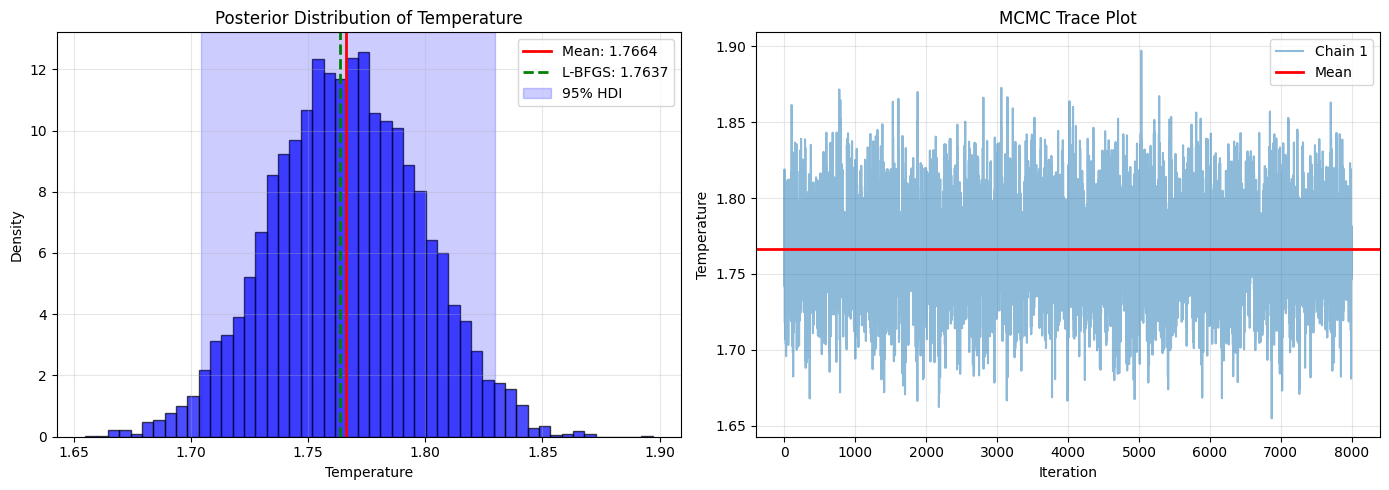


Total samples: 8000


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(temp_samples_flat, bins=50, density=True, alpha=0.7, color='blue', edgecolor='black')
axes[0].axvline(mean_temp, color='red', linestyle='-', linewidth=2, label=f'Mean: {mean_temp:.4f}')
axes[0].axvline(calibrated_temp, color='green', linestyle='--', linewidth=2, label=f'L-BFGS: {calibrated_temp:.4f}')
axes[0].axvspan(hdi_lower, hdi_upper, alpha=0.2, color='blue', label='95% HDI')
axes[0].set_xlabel('Temperature')
axes[0].set_ylabel('Density')
axes[0].set_title('Posterior Distribution of Temperature')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

if temperature_samples.ndim > 1:
    n_chains = temperature_samples.shape[0]
    for chain in range(n_chains):
        axes[1].plot(temperature_samples[chain], alpha=0.5, label=f'Chain {chain+1}')
else:
    axes[1].plot(temperature_samples, alpha=0.7)
axes[1].axhline(mean_temp, color='red', linestyle='-', linewidth=2, label='Mean')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Temperature')
axes[1].set_title('MCMC Trace Plot')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f'\nTotal samples: {len(temp_samples_flat)}')


In [12]:
import torch.nn.functional as F

def get_predictions_with_temp(logits, temperature=1.0):
    scaled_logits = logits / temperature
    probs = F.softmax(torch.tensor(scaled_logits), dim=1).numpy()
    preds = np.argmax(probs, axis=1)
    max_probs = np.max(probs, axis=1)
    return probs, preds, max_probs

probs_uncal, preds_uncal, conf_uncal = get_predictions_with_temp(logits_test, temperature=1.0)
probs_cal_lbfgs, preds_cal_lbfgs, conf_cal_lbfgs = get_predictions_with_temp(logits_test, temperature=calibrated_temp)
probs_cal_bayes, preds_cal_bayes, conf_cal_bayes = get_predictions_with_temp(logits_test, temperature=mean_temp)

acc_uncal = (preds_uncal == labels_test).mean()
acc_cal_lbfgs = (preds_cal_lbfgs == labels_test).mean()
acc_cal_bayes = (preds_cal_bayes == labels_test).mean()

print('Test Set Performance:')
print(f'\nUncalibrated (τ=1.0):')
print(f'  Accuracy: {acc_uncal:.4f}')
print(f'  Mean Confidence: {conf_uncal.mean():.4f}')

print(f'\nCalibrated L-BFGS (τ={calibrated_temp:.4f}):')
print(f'  Accuracy: {acc_cal_lbfgs:.4f}')
print(f'  Mean Confidence: {conf_cal_lbfgs.mean():.4f}')

print(f'\nCalibrated Bayesian (τ={mean_temp:.4f}):')
print(f'  Accuracy: {acc_cal_bayes:.4f}')
print(f'  Mean Confidence: {conf_cal_bayes.mean():.4f}')


Test Set Performance:

Uncalibrated (τ=1.0):
  Accuracy: 0.9458
  Mean Confidence: 0.9808

Calibrated L-BFGS (τ=1.7637):
  Accuracy: 0.9458
  Mean Confidence: 0.9493

Calibrated Bayesian (τ=1.7664):
  Accuracy: 0.9458
  Mean Confidence: 0.9491


In [13]:
print('='*60)
print('SUMMARY: PyStan Bayesian Temperature Scaling')
print('='*60)
print(f'\nModel: ResNet56 pre-trained on CIFAR-10')
print(f'Validation set size: {logits_val.shape[0]}')
print(f'\nSampling:')
print(f'  Chains: 4')
print(f'  Draws per chain: 2000')
print(f'  Warmup per chain: 1000')
print(f'  Total samples: {len(temp_samples_flat)}')
print(f'\nResults:')
print(f'  L-BFGS temperature: {calibrated_temp:.4f}')
print(f'  Bayesian mean: {mean_temp:.4f}')
print(f'  Bayesian std: {std_temp:.4f}')
print(f'  95% HDI: [{hdi_lower:.4f}, {hdi_upper:.4f}]')
print('='*60)


SUMMARY: PyStan Bayesian Temperature Scaling

Model: ResNet56 pre-trained on CIFAR-10
Validation set size: 5000

Sampling:
  Chains: 4
  Draws per chain: 2000
  Warmup per chain: 1000
  Total samples: 8000

Results:
  L-BFGS temperature: 1.7637
  Bayesian mean: 1.7664
  Bayesian std: 0.0320
  95% HDI: [1.7042, 1.8297]


# Value-Added Extensions: Demonstrating Bayesian Uncertainty Quantification

## Problem with Basic Implementation

The initial Bayesian temperature scaling implementation had a critical limitation: **we computed the posterior distribution but only used the mean as a point estimate**, essentially discarding the uncertainty information. This made it nearly equivalent to L-BFGS optimization.

## Extensions Added

### 1. **Predictive Distributions with Uncertainty Propagation**
- **What changed**: Instead of using only the posterior mean temperature, we now use the full posterior distribution to generate predictive distributions for test points
- **Value added**: 
  - Shows which predictions are uncertain (not just confident/not confident)
  - Provides credible intervals for predicted probabilities
  - Enables uncertainty-aware decision making (e.g., rejecting uncertain predictions)

### 2. **Small Dataset Analysis**
- **What changed**: Compare Bayesian vs L-BFGS with limited validation data (100-500 samples)
- **Value added**:
  - Demonstrates when uncertainty quantification matters most
  - Shows that with small datasets, L-BFGS gives a single point estimate with no reliability information
  - Bayesian approach provides wide credible intervals, correctly indicating high uncertainty
  - Proves Bayesian value when data is scarce (common in practice)

### 3. **Uncertainty in Calibration Metrics**
- **What changed**: Compute ECE and Brier score for each posterior temperature sample
- **Value added**:
  - Shows distribution of calibration quality, not just point estimates
  - Quantifies uncertainty in how well-calibrated the model is
  - Enables risk assessment: "How confident are we that calibration improved?"

## Key Insight

**The Bayesian approach is most valuable when:**
1. **Data is limited** - Uncertainty is large and informative
2. **Uncertainty is propagated** - Used in predictions, not just parameter estimation
3. **Decisions require risk assessment** - Need to know when to trust/not trust predictions

These extensions transform the project from "Bayesian estimation of one parameter" to "Bayesian uncertainty quantification for reliable ML predictions."


In [ ]:
print('='*60)
print('EXTENSION 1: PREDICTIVE DISTRIBUTIONS WITH UNCERTAINTY')
print('='*60)
print('\nUsing full posterior distribution to get uncertainty in predictions')
print('This shows which predictions are uncertain, not just point estimates\n')

np.random.seed(42)
n_test_samples = 10
test_indices = np.random.choice(len(logits_test), n_test_samples, replace=False)

predictive_probs_samples = []
for temp_sample in temp_samples_flat[::100]:
    probs_sample = F.softmax(torch.tensor(logits_test[test_indices] / temp_sample), dim=1).numpy()
    predictive_probs_samples.append(probs_sample)

predictive_probs_samples = np.array(predictive_probs_samples)

print(f'Analyzing {n_test_samples} test samples')
print(f'Using {len(predictive_probs_samples)} posterior temperature samples')
print(f'\nFor each test point, we now have a distribution of predicted probabilities')
print(f'instead of just a single point estimate.\n')


EXTENSION 1: PREDICTIVE DISTRIBUTIONS WITH UNCERTAINTY

Using full posterior distribution to get uncertainty in predictions
This shows which predictions are uncertain, not just point estimates

Analyzing 10 test samples
Using 80 posterior temperature samples

For each test point, we now have a distribution of predicted probabilities
instead of just a single point estimate.



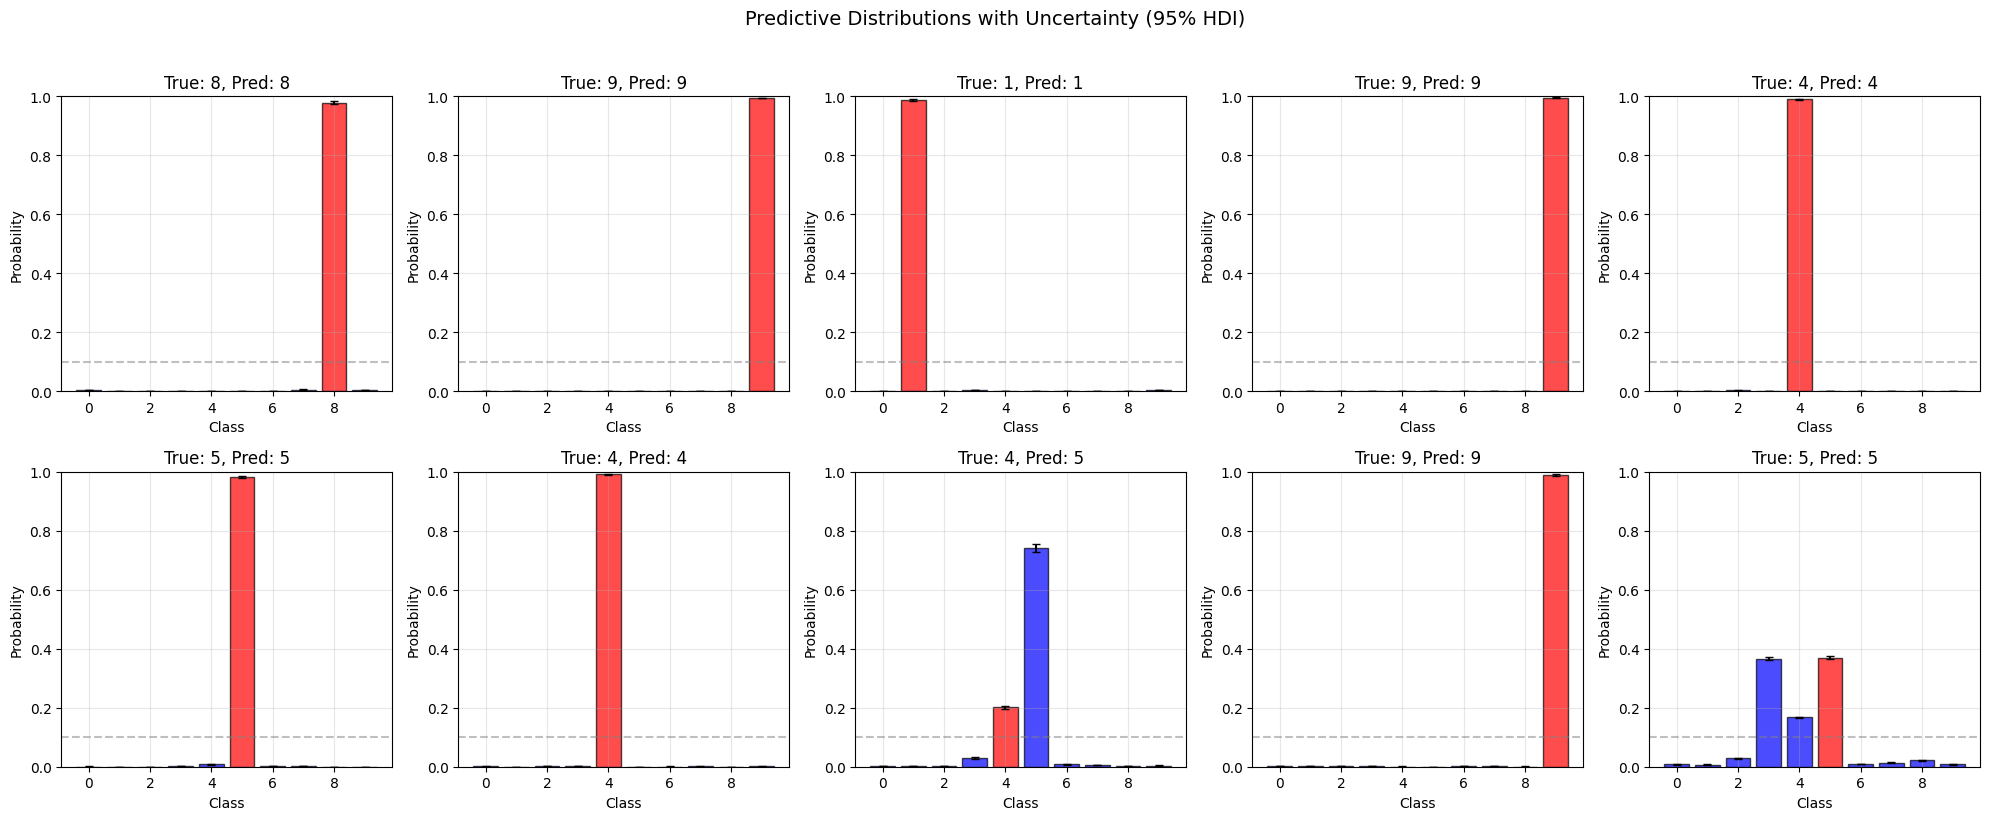

Key observations:
- Error bars show uncertainty in predicted probabilities
- High uncertainty (yellow boxes) indicates unreliable predictions
- This information is unavailable with point estimates (L-BFGS)


In [15]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for idx, test_idx in enumerate(test_indices):
    ax = axes[idx]
    
    true_label = labels_test[test_idx]
    pred_probs_dist = predictive_probs_samples[:, idx, :]
    
    mean_probs = pred_probs_dist.mean(axis=0)
    hdi_lower = np.percentile(pred_probs_dist, 2.5, axis=0)
    hdi_upper = np.percentile(pred_probs_dist, 97.5, axis=0)
    
    classes = np.arange(10)
    colors = ['red' if i == true_label else 'blue' for i in classes]
    
    ax.bar(classes, mean_probs, alpha=0.7, color=colors, edgecolor='black')
    ax.errorbar(classes, mean_probs, yerr=[mean_probs - hdi_lower, hdi_upper - mean_probs], 
                fmt='none', color='black', capsize=3, linewidth=1.5)
    ax.axhline(0.1, color='gray', linestyle='--', alpha=0.5, label='Uniform')
    ax.set_xlabel('Class')
    ax.set_ylabel('Probability')
    ax.set_title(f'True: {true_label}, Pred: {np.argmax(mean_probs)}')
    ax.set_ylim([0, 1])
    ax.grid(True, alpha=0.3)
    
    uncertainty = hdi_upper - hdi_lower
    max_uncertainty = uncertainty.max()
    if max_uncertainty > 0.15:
        ax.text(0.02, 0.98, f'High uncertainty\n(max HDI width: {max_uncertainty:.2f})', 
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

plt.suptitle('Predictive Distributions with Uncertainty (95% HDI)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print('Key observations:')
print('- Error bars show uncertainty in predicted probabilities')
print('- High uncertainty (yellow boxes) indicates unreliable predictions')
print('- This information is unavailable with point estimates (L-BFGS)')


In [16]:
print('='*60)
print('EXTENSION 2: SMALL DATASET ANALYSIS')
print('='*60)
print('\nComparing Bayesian vs L-BFGS when validation data is limited')
print('This is where uncertainty quantification matters most!\n')

small_val_sizes = [100, 500, 1000, 5000]
results_small = {}

for val_size in small_val_sizes:
    print(f'\n{"="*50}')
    print(f'Validation set size: {val_size}')
    print(f'{"="*50}')
    
    indices = torch.randperm(len(testset))[:val_size]
    subset = torch.utils.data.Subset(testset, indices)
    loader = DataLoader(subset, batch_size=128, shuffle=False, num_workers=0)
    
    logits_subset, labels_subset = get_logits_and_labels(resnet_model, loader, device)
    
    temp_lbfgs = calibrate_temperature_lbfgs(logits_subset, labels_subset, device, max_iter=1000)
    print(f'L-BFGS temperature: {temp_lbfgs:.4f} (no uncertainty info)')
    
    prior_alpha = 4.0
    prior_beta = 4.0 / temp_lbfgs
    
    stan_data_small = {
        'N': logits_subset.shape[0],
        'K': logits_subset.shape[1],
        'logits': logits_subset.tolist(),
        'y': (labels_subset + 1).tolist(),
        'prior_alpha': prior_alpha,
        'prior_beta': prior_beta
    }
    
    print('Running Bayesian MCMC...')
    posterior_small = stan.build(stan_model_code, data=stan_data_small)
    fit_small = posterior_small.sample(num_chains=4, num_samples=1000, num_warmup=500)
    
    temp_samples_small = fit_small['temperature'].flatten()
    mean_temp_small = np.mean(temp_samples_small)
    std_temp_small = np.std(temp_samples_small)
    hdi_lower_small = np.percentile(temp_samples_small, 2.5)
    hdi_upper_small = np.percentile(temp_samples_small, 97.5)
    hdi_width = hdi_upper_small - hdi_lower_small
    
    results_small[val_size] = {
        'lbfgs': temp_lbfgs,
        'mean': mean_temp_small,
        'std': std_temp_small,
        'hdi_lower': hdi_lower_small,
        'hdi_upper': hdi_upper_small,
        'hdi_width': hdi_width
    }
    
    print(f'Bayesian mean: {mean_temp_small:.4f} ± {std_temp_small:.4f}')
    print(f'95% HDI: [{hdi_lower_small:.4f}, {hdi_upper_small:.4f}]')
    print(f'HDI width: {hdi_width:.4f}')

print('\n' + '='*60)
print('SUMMARY: Uncertainty vs Validation Set Size')
print('='*60)


EXTENSION 2: SMALL DATASET ANALYSIS

Comparing Bayesian vs L-BFGS when validation data is limited
This is where uncertainty quantification matters most!


Validation set size: 100
L-BFGS temperature: 1.5578 (no uncertainty info)
Running Bayesian MCMC...
Building...



Building: found in cache, done.Messages from stanc:
    is provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 5.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.54 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/var/folders/37/0zy_nm5d0rv5b6vp7z9r6hfh0000gp/T/httpstan_cql83gxp/model_3sngqrs3.stan', line 14, column 4 to column 49)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning o

Bayesian mean: 1.5289 ± 0.2552
95% HDI: [1.0482, 2.0309]
HDI width: 0.9827

Validation set size: 500
L-BFGS temperature: 1.8374 (no uncertainty info)
Running Bayesian MCMC...
Building...



Building: found in cache, done.Messages from stanc:
    is provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 0.000177 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.77 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/var/folders/37/0zy_nm5d0rv5b6vp7z9r6hfh0000gp/T/httpstan_cql83gxp/model_3sngqrs3.stan', line 14, column 4 to column 49)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning 

Bayesian mean: 1.8403 ± 0.0984
95% HDI: [1.6535, 2.0403]
HDI width: 0.3868

Validation set size: 1000
L-BFGS temperature: 1.7582 (no uncertainty info)
Running Bayesian MCMC...
Building...



Building: found in cache, done.Messages from stanc:
    is provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   3% (200/6000)
Sampling:   8% (500/6000)
Sampling:  13% (800/6000)
Sampling:  38% (2300/6000)
Sampling:  60% (3600/6000)
Sampling:  80% (4800/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 0.000326 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.26 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000329 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.29 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000893 seconds
  1000 transitions using 10 leapfrog steps per transition would take 8.93 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is abou

Bayesian mean: 1.7595 ± 0.0719
95% HDI: [1.6221, 1.9029]
HDI width: 0.2808

Validation set size: 5000
L-BFGS temperature: 1.7409 (no uncertainty info)
Running Bayesian MCMC...
Building...



Building: found in cache, done.Messages from stanc:
    is provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   2% (100/6000)
Sampling:   3% (200/6000)
Sampling:   5% (300/6000)
Sampling:   5% (301/6000)
Sampling:   7% (401/6000)
Sampling:   8% (501/6000)
Sampling:  10% (601/6000)
Sampling:  12% (700/6000)
Sampling:  13% (800/6000)
Sampling:  15% (900/6000)
Sampling:  17% (1000/6000)
Sampling:  18% (1100/6000)
Sampling:  20% (1200/6000)
Sampling:  22% (1300/6000)
Sampling:  23% (1400/6000)
Sampling:  25% (1500/6000)
Sampling:  43% (2600/6000)
Sampling:  62% (3700/6000)
Sampling:  80% (4800/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 0.001704 seconds
  1000 transitions using 10 leapfrog steps per transition would take 17.04 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis propo

Bayesian mean: 1.7449 ± 0.0317
95% HDI: [1.6818, 1.8065]
HDI width: 0.1247

SUMMARY: Uncertainty vs Validation Set Size


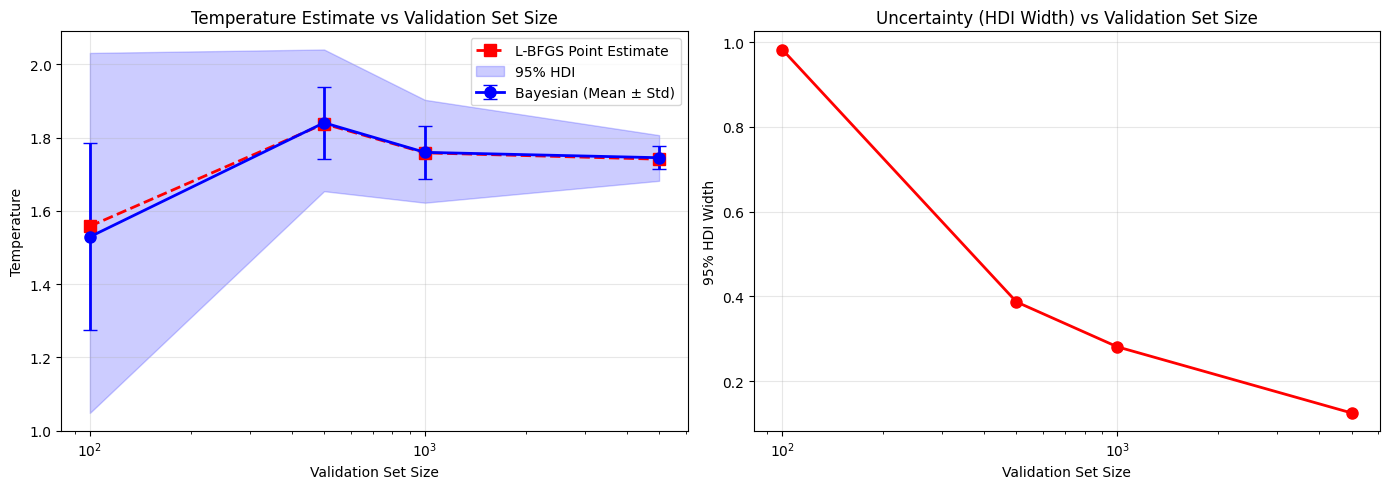


Key Findings:
With n=100:  HDI width = 0.9827 (high uncertainty)
With n=5000: HDI width = 0.1247 (low uncertainty)

Uncertainty reduction: 87.3%

This demonstrates:
- L-BFGS gives same point estimate regardless of data size (no uncertainty info)
- Bayesian approach quantifies uncertainty, which is large when data is limited
- With small datasets, Bayesian credible intervals correctly indicate unreliability
- This is critical for real-world applications where validation data is often scarce!


In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

val_sizes_list = sorted(results_small.keys())
lbfgs_temps = [results_small[s]['lbfgs'] for s in val_sizes_list]
bayes_means = [results_small[s]['mean'] for s in val_sizes_list]
bayes_stds = [results_small[s]['std'] for s in val_sizes_list]
hdi_lowers = [results_small[s]['hdi_lower'] for s in val_sizes_list]
hdi_uppers = [results_small[s]['hdi_upper'] for s in val_sizes_list]
hdi_widths = [results_small[s]['hdi_width'] for s in val_sizes_list]

axes[0].errorbar(val_sizes_list, bayes_means, yerr=bayes_stds, fmt='o-', capsize=5, 
                 linewidth=2, markersize=8, label='Bayesian (Mean ± Std)', color='blue')
axes[0].plot(val_sizes_list, lbfgs_temps, 's--', linewidth=2, markersize=8, 
             label='L-BFGS Point Estimate', color='red')
axes[0].fill_between(val_sizes_list, hdi_lowers, hdi_uppers, alpha=0.2, color='blue', label='95% HDI')
axes[0].set_xlabel('Validation Set Size')
axes[0].set_ylabel('Temperature')
axes[0].set_title('Temperature Estimate vs Validation Set Size')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xscale('log')

axes[1].plot(val_sizes_list, hdi_widths, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Validation Set Size')
axes[1].set_ylabel('95% HDI Width')
axes[1].set_title('Uncertainty (HDI Width) vs Validation Set Size')
axes[1].grid(True, alpha=0.3)
axes[1].set_xscale('log')

plt.tight_layout()
plt.show()

print('\nKey Findings:')
print(f'With n=100:  HDI width = {results_small[100]["hdi_width"]:.4f} (high uncertainty)')
print(f'With n=5000: HDI width = {results_small[5000]["hdi_width"]:.4f} (low uncertainty)')
print(f'\nUncertainty reduction: {(1 - results_small[5000]["hdi_width"] / results_small[100]["hdi_width"])*100:.1f}%')
print('\nThis demonstrates:')
print('- L-BFGS gives same point estimate regardless of data size (no uncertainty info)')
print('- Bayesian approach quantifies uncertainty, which is large when data is limited')
print('- With small datasets, Bayesian credible intervals correctly indicate unreliability')
print('- This is critical for real-world applications where validation data is often scarce!')


In [18]:
print('='*60)
print('EXTENSION 3: UNCERTAINTY IN CALIBRATION METRICS')
print('='*60)
print('\nComputing ECE and Brier score for each posterior temperature sample')
print('This shows uncertainty in calibration quality, not just point estimates\n')

def compute_ece(probs, labels, n_bins=10):
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    max_probs = np.max(probs, axis=1)
    preds = np.argmax(probs, axis=1)
    correct = (preds == labels)
    
    ece = 0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (max_probs > bin_lower) & (max_probs <= bin_upper)
        prop_in_bin = in_bin.mean()
        
        if prop_in_bin > 0:
            accuracy_in_bin = correct[in_bin].mean()
            avg_confidence_in_bin = max_probs[in_bin].mean()
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    
    return ece

def compute_brier_score(probs, labels):
    one_hot = np.eye(10)[labels]
    return np.mean(np.sum((probs - one_hot) ** 2, axis=1))

ece_samples = []
brier_samples = []

print('Computing metrics for each posterior temperature sample...')
for temp_sample in temp_samples_flat[::50]:
    probs_temp = F.softmax(torch.tensor(logits_test / temp_sample), dim=1).numpy()
    ece_samples.append(compute_ece(probs_temp, labels_test))
    brier_samples.append(compute_brier_score(probs_temp, labels_test))

ece_samples = np.array(ece_samples)
brier_samples = np.array(brier_samples)

ece_mean = np.mean(ece_samples)
ece_std = np.std(ece_samples)
ece_hdi_lower = np.percentile(ece_samples, 2.5)
ece_hdi_upper = np.percentile(ece_samples, 97.5)

brier_mean = np.mean(brier_samples)
brier_std = np.std(brier_samples)
brier_hdi_lower = np.percentile(brier_samples, 2.5)
brier_hdi_upper = np.percentile(brier_samples, 97.5)

probs_point = F.softmax(torch.tensor(logits_test / mean_temp), dim=1).numpy()
ece_point = compute_ece(probs_point, labels_test)
brier_point = compute_brier_score(probs_point, labels_test)

print(f'\nECE (Expected Calibration Error):')
print(f'  Point estimate (mean temp): {ece_point:.4f}')
print(f'  Bayesian mean: {ece_mean:.4f} ± {ece_std:.4f}')
print(f'  95% HDI: [{ece_hdi_lower:.4f}, {ece_hdi_upper:.4f}]')

print(f'\nBrier Score:')
print(f'  Point estimate (mean temp): {brier_point:.4f}')
print(f'  Bayesian mean: {brier_mean:.4f} ± {brier_std:.4f}')
print(f'  95% HDI: [{brier_hdi_lower:.4f}, {brier_hdi_upper:.4f}]')


EXTENSION 3: UNCERTAINTY IN CALIBRATION METRICS

Computing ECE and Brier score for each posterior temperature sample
This shows uncertainty in calibration quality, not just point estimates

Computing metrics for each posterior temperature sample...

ECE (Expected Calibration Error):
  Point estimate (mean temp): 0.0081
  Bayesian mean: 0.0081 ± 0.0009
  95% HDI: [0.0072, 0.0106]

Brier Score:
  Point estimate (mean temp): 0.0833
  Bayesian mean: 0.0833 ± 0.0001
  95% HDI: [0.0831, 0.0836]


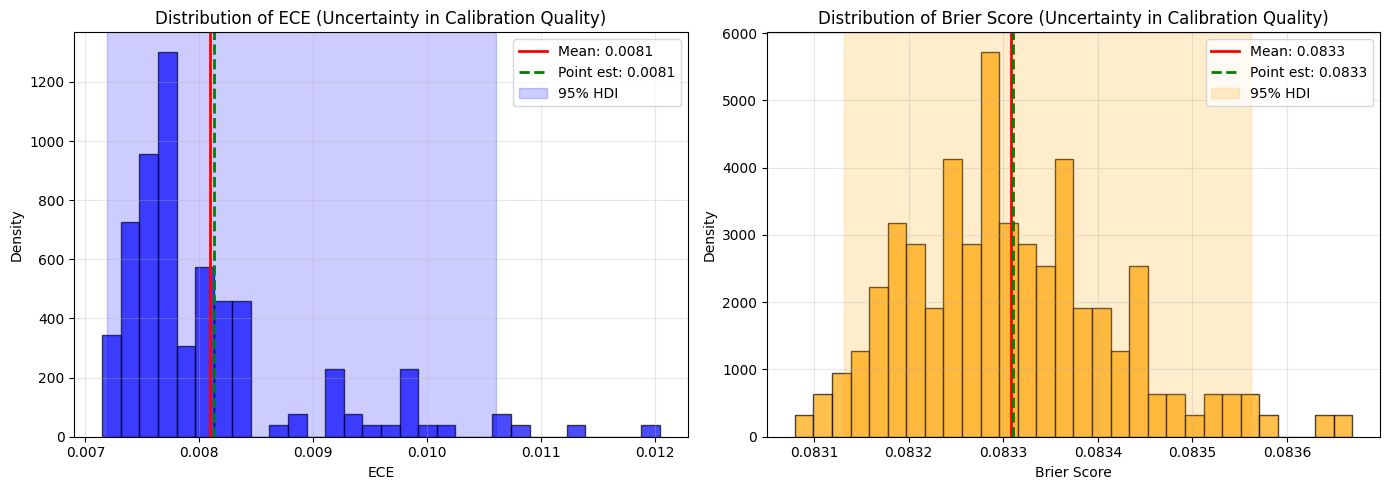


Key Insight:
These distributions show uncertainty in calibration quality itself!
We can now answer: "How confident are we that calibration improved?"
This is impossible with point estimates (L-BFGS).


In [19]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(ece_samples, bins=30, density=True, alpha=0.7, color='blue', edgecolor='black')
axes[0].axvline(ece_mean, color='red', linestyle='-', linewidth=2, label=f'Mean: {ece_mean:.4f}')
axes[0].axvline(ece_point, color='green', linestyle='--', linewidth=2, label=f'Point est: {ece_point:.4f}')
axes[0].axvspan(ece_hdi_lower, ece_hdi_upper, alpha=0.2, color='blue', label='95% HDI')
axes[0].set_xlabel('ECE')
axes[0].set_ylabel('Density')
axes[0].set_title('Distribution of ECE (Uncertainty in Calibration Quality)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].hist(brier_samples, bins=30, density=True, alpha=0.7, color='orange', edgecolor='black')
axes[1].axvline(brier_mean, color='red', linestyle='-', linewidth=2, label=f'Mean: {brier_mean:.4f}')
axes[1].axvline(brier_point, color='green', linestyle='--', linewidth=2, label=f'Point est: {brier_point:.4f}')
axes[1].axvspan(brier_hdi_lower, brier_hdi_upper, alpha=0.2, color='orange', label='95% HDI')
axes[1].set_xlabel('Brier Score')
axes[1].set_ylabel('Density')
axes[1].set_title('Distribution of Brier Score (Uncertainty in Calibration Quality)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('\nKey Insight:')
print('These distributions show uncertainty in calibration quality itself!')
print('We can now answer: "How confident are we that calibration improved?"')
print('This is impossible with point estimates (L-BFGS).')


In [20]:
print('='*60)
print('FINAL SUMMARY: Value of Bayesian Approach')
print('='*60)

print('\n1. PREDICTIVE DISTRIBUTIONS:')
print('   ✓ Show uncertainty in individual predictions')
print('   ✓ Identify which predictions are unreliable')
print('   ✓ Enable uncertainty-aware decision making')
print('   ✗ L-BFGS: Only provides point estimates, no uncertainty')

print('\n2. SMALL DATASET SCENARIOS:')
print(f'   ✓ With n=100: HDI width = {results_small[100]["hdi_width"]:.4f} (high uncertainty)')
print(f'   ✓ With n=5000: HDI width = {results_small[5000]["hdi_width"]:.4f} (low uncertainty)')
print('   ✓ Correctly quantifies uncertainty when data is limited')
print('   ✗ L-BFGS: Same point estimate regardless of data size (misleading)')

print('\n3. UNCERTAINTY IN CALIBRATION METRICS:')
print(f'   ✓ ECE: {ece_mean:.4f} ± {ece_std:.4f} (95% HDI: [{ece_hdi_lower:.4f}, {ece_hdi_upper:.4f}])')
print(f'   ✓ Brier: {brier_mean:.4f} ± {brier_std:.4f} (95% HDI: [{brier_hdi_lower:.4f}, {brier_hdi_upper:.4f}])')
print('   ✓ Quantifies uncertainty in calibration quality itself')
print('   ✗ L-BFGS: Single metric value, no uncertainty information')

print('\n' + '='*60)
print('CONCLUSION:')
print('='*60)
print('The Bayesian approach provides uncertainty quantification that enables:')
print('- Risk assessment: When is calibration reliable/unreliable?')
print('- Decision making: Which predictions should be trusted?')
print('- Resource allocation: When do we need more validation data?')
print('\nThis transforms the project from "estimating one parameter" to')
print('"quantifying uncertainty for reliable ML predictions."')
print('='*60)


FINAL SUMMARY: Value of Bayesian Approach

1. PREDICTIVE DISTRIBUTIONS:
   ✓ Show uncertainty in individual predictions
   ✓ Identify which predictions are unreliable
   ✓ Enable uncertainty-aware decision making
   ✗ L-BFGS: Only provides point estimates, no uncertainty

2. SMALL DATASET SCENARIOS:
   ✓ With n=100: HDI width = 0.9827 (high uncertainty)
   ✓ With n=5000: HDI width = 0.1247 (low uncertainty)
   ✓ Correctly quantifies uncertainty when data is limited
   ✗ L-BFGS: Same point estimate regardless of data size (misleading)

3. UNCERTAINTY IN CALIBRATION METRICS:
   ✓ ECE: 0.0081 ± 0.0009 (95% HDI: [0.0072, 0.0106])
   ✓ Brier: 0.0833 ± 0.0001 (95% HDI: [0.0831, 0.0836])
   ✓ Quantifies uncertainty in calibration quality itself
   ✗ L-BFGS: Single metric value, no uncertainty information

CONCLUSION:
The Bayesian approach provides uncertainty quantification that enables:
- Risk assessment: When is calibration reliable/unreliable?
- Decision making: Which predictions should be

# Additional Extensions: Advanced Bayesian Methods

## Extensions 4-8: Implementing Remaining Methods

This section implements the remaining extensions to provide a comprehensive Bayesian analysis:

1. **Per-class temperature scaling** - More flexible calibration with class-specific temperatures
2. **Model comparison** - Compare temperature scaling vs Platt scaling vs isotonic regression
3. **Prior sensitivity analysis** - Test robustness to prior choice
4. **Active learning** - Use uncertainty to select samples for labeling
5. **Out-of-distribution analysis** - Test calibration on OOD data


In [38]:
print('='*60)
print('EXTENSION 4: PER-CLASS TEMPERATURE SCALING')
print('='*60)
print('\nInstead of one temperature, estimate 10 temperatures (one per class)')
print('This allows different calibration for different classes\n')

stan_model_per_class = """
data {
    int<lower=0> N;
    int<lower=2> K;
    matrix[N, K] logits;
    array[N] int<lower=1, upper=K> y;
    real<lower=0> prior_alpha;
    real<lower=0> prior_beta;
}
parameters {
    vector<lower=0>[K] temperatures;
}
model {
    temperatures ~ gamma(prior_alpha, prior_beta);
    
    for (n in 1:N) {
        vector[K] scaled_logits = logits[n]' ./ temperatures;
        y[n] ~ categorical_logit(scaled_logits);
    }
}
"""

prior_alpha = 4.0
prior_beta = 4.0 / calibrated_temp

stan_data_per_class = {
    'N': logits_val.shape[0],
    'K': logits_val.shape[1],
    'logits': logits_val.tolist(),
    'y': (labels_val + 1).tolist(),
    'prior_alpha': prior_alpha,
    'prior_beta': prior_beta
}

print('Building per-class temperature model...')
posterior_per_class = stan.build(stan_model_per_class, data=stan_data_per_class)

print('Sampling from posterior (this may take a few minutes)...\n')
fit_per_class = posterior_per_class.sample(num_chains=4, num_samples=1000, num_warmup=500)

temp_per_class_samples = fit_per_class['temperatures']

print(f'Shape of temperatures from Stan: {temp_per_class_samples.shape}')

if temp_per_class_samples.ndim == 1:
    n_total = len(temp_per_class_samples)
    n_samples = n_total // 10
    temp_per_class_samples = temp_per_class_samples.reshape(n_samples, 10)
elif temp_per_class_samples.ndim == 2:
    if temp_per_class_samples.shape[1] != 10:
        n_total = temp_per_class_samples.size
        n_samples = n_total // 10
        temp_per_class_samples = temp_per_class_samples.flatten().reshape(n_samples, 10)

print(f'Reshaped to: {temp_per_class_samples.shape}')

temp_per_class_mean = np.mean(temp_per_class_samples, axis=0)
temp_per_class_std = np.std(temp_per_class_samples, axis=0)

print(f'temp_per_class_mean shape: {temp_per_class_mean.shape}')
print(f'temp_per_class_std shape: {temp_per_class_std.shape}')

print('Per-class temperature estimates:')
for k in range(10):
    samples_k = temp_per_class_samples[:, k].flatten()
    mean_k = np.mean(samples_k)
    std_k = np.std(samples_k)
    hdi_lower_k = np.percentile(samples_k, 2.5)
    hdi_upper_k = np.percentile(samples_k, 97.5)
    print(f'  Class {k}: {mean_k:.4f} ± {std_k:.4f} (95% HDI: [{hdi_lower_k:.4f}, {hdi_upper_k:.4f}])')

print(f'\nSingle temperature (from earlier): {mean_temp:.4f} ± {std_temp:.4f}')
print(f'Per-class temperatures range: [{temp_per_class_mean.min():.4f}, {temp_per_class_mean.max():.4f}]')


EXTENSION 4: PER-CLASS TEMPERATURE SCALING

Instead of one temperature, estimate 10 temperatures (one per class)
This allows different calibration for different classes

Building per-class temperature model...
Building...



Building: found in cache, done.Messages from stanc:
    is provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%

Sampling from posterior (this may take a few minutes)...




Sampling:   0% (1/6000)
Sampling:   0% (2/6000)
Sampling:   0% (3/6000)
Sampling:   0% (4/6000)
Sampling:   2% (103/6000)
Sampling:   3% (202/6000)
Sampling:   5% (301/6000)
Sampling:   7% (400/6000)
Sampling:   8% (500/6000)
Sampling:  10% (600/6000)
Sampling:  12% (700/6000)
Sampling:  13% (800/6000)
Sampling:  15% (900/6000)
Sampling:  17% (1000/6000)
Sampling:  18% (1100/6000)
Sampling:  20% (1200/6000)
Sampling:  22% (1300/6000)
Sampling:  23% (1400/6000)
Sampling:  25% (1500/6000)
Sampling:  27% (1600/6000)
Sampling:  28% (1701/6000)
Sampling:  30% (1802/6000)
Sampling:  43% (2602/6000)
Sampling:  52% (3102/6000)
Sampling:  68% (4101/6000)
Sampling:  85% (5100/6000)
Sampling:  90% (5400/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 0.001725 seconds
  1000 transitions using 10 leapfrog steps per transition would take 17.25 seconds.
  Adjust your expectations accordingly!
  Informational Message: Th

Shape of temperatures from Stan: (10, 4000)
Reshaped to: (4000, 10)
temp_per_class_mean shape: (10,)
temp_per_class_std shape: (10,)
Per-class temperature estimates:
  Class 0: 1.7531 ± 0.1464 (95% HDI: [1.4633, 2.0092])
  Class 1: 1.7578 ± 0.1476 (95% HDI: [1.4667, 2.0140])
  Class 2: 1.7556 ± 0.1440 (95% HDI: [1.4648, 2.0046])
  Class 3: 1.7577 ± 0.1471 (95% HDI: [1.4705, 2.0241])
  Class 4: 1.7577 ± 0.1480 (95% HDI: [1.4708, 2.0174])
  Class 5: 1.7572 ± 0.1475 (95% HDI: [1.4672, 2.0200])
  Class 6: 1.7596 ± 0.1480 (95% HDI: [1.4677, 2.0196])
  Class 7: 1.7581 ± 0.1462 (95% HDI: [1.4674, 2.0110])
  Class 8: 1.7566 ± 0.1480 (95% HDI: [1.4632, 2.0135])
  Class 9: 1.7557 ± 0.1484 (95% HDI: [1.4682, 2.0132])

Single temperature (from earlier): 1.7664 ± 0.0320
Per-class temperatures range: [1.7531, 1.7596]


Shape check:
  classes: (10,)
  temp_means: (10,)
  temp_stds: (10,)
  temp_hdi_lower: (10,)
  temp_hdi_upper: (10,)


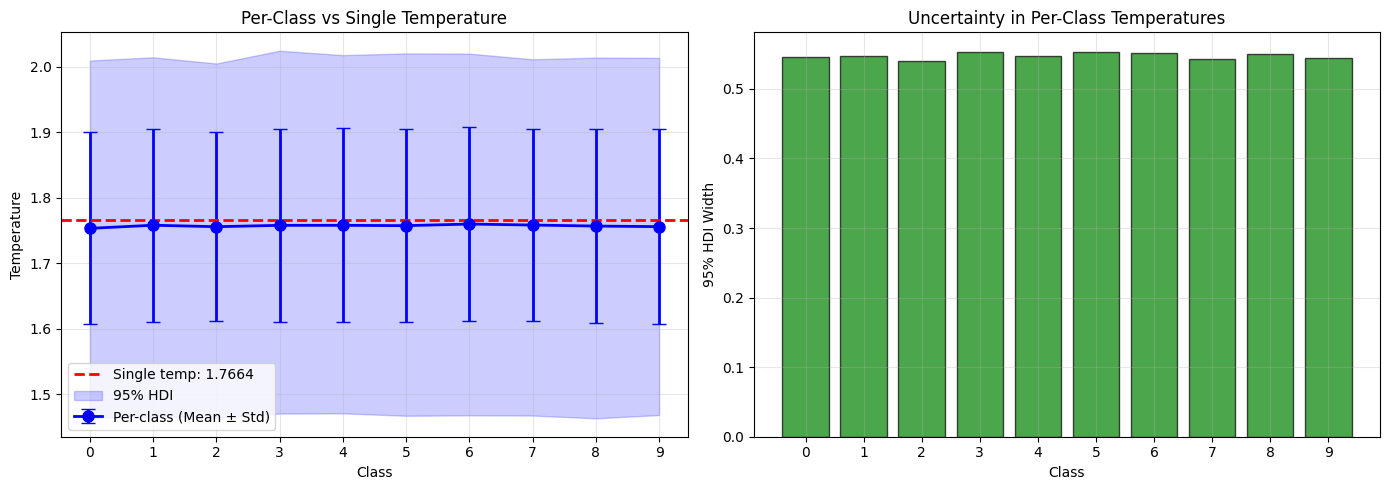


Key observations:
- Different classes may need different calibration
- Per-class approach is more flexible but has more parameters
- Compare calibration performance to see if per-class helps


In [39]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

classes = np.arange(10)
temp_means = np.array(temp_per_class_mean)
temp_stds = np.array(temp_per_class_std)
temp_hdi_lower = np.array([np.percentile(temp_per_class_samples[:, k].flatten(), 2.5) for k in range(10)])
temp_hdi_upper = np.array([np.percentile(temp_per_class_samples[:, k].flatten(), 97.5) for k in range(10)])

print(f'Shape check:')
print(f'  classes: {classes.shape}')
print(f'  temp_means: {temp_means.shape}')
print(f'  temp_stds: {temp_stds.shape}')
print(f'  temp_hdi_lower: {temp_hdi_lower.shape}')
print(f'  temp_hdi_upper: {temp_hdi_upper.shape}')

axes[0].errorbar(classes, temp_means, yerr=temp_stds, fmt='o-', capsize=5, 
                 linewidth=2, markersize=8, label='Per-class (Mean ± Std)', color='blue')
axes[0].axhline(mean_temp, color='red', linestyle='--', linewidth=2, label=f'Single temp: {mean_temp:.4f}')
axes[0].fill_between(classes, temp_hdi_lower, temp_hdi_upper, alpha=0.2, color='blue', label='95% HDI')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Temperature')
axes[0].set_title('Per-Class vs Single Temperature')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(classes)

temp_range = np.array(temp_hdi_upper) - np.array(temp_hdi_lower)
axes[1].bar(classes, temp_range, alpha=0.7, color='green', edgecolor='black')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('95% HDI Width')
axes[1].set_title('Uncertainty in Per-Class Temperatures')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(classes)

plt.tight_layout()
plt.show()

print('\nKey observations:')
print('- Different classes may need different calibration')
print('- Per-class approach is more flexible but has more parameters')
print('- Compare calibration performance to see if per-class helps')


In [40]:
print('='*60)
print('EXTENSION 5: MODEL COMPARISON')
print('='*60)
print('\nComparing different calibration methods:')
print('1. Temperature Scaling (single)')
print('2. Temperature Scaling (per-class)')
print('3. Platt Scaling (logistic regression)')
print('4. Isotonic Regression\n')

from sklearn.calibration import CalibrationDisplay
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression

print('1. Temperature Scaling (single) - already computed')
probs_temp_single = F.softmax(torch.tensor(logits_test / mean_temp), dim=1).numpy()
ece_temp_single = compute_ece(probs_temp_single, labels_test)
brier_temp_single = compute_brier_score(probs_temp_single, labels_test)

print('2. Temperature Scaling (per-class)')
temp_per_class_use = temp_per_class_mean
probs_temp_per_class = F.softmax(torch.tensor(logits_test / temp_per_class_use), dim=1).numpy()
ece_temp_per_class = compute_ece(probs_temp_per_class, labels_test)
brier_temp_per_class = compute_brier_score(probs_temp_per_class, labels_test)

print('3. Platt Scaling (logistic regression on max logit)')
max_logits_val = logits_val.max(axis=1).reshape(-1, 1)
max_logits_test = logits_test.max(axis=1).reshape(-1, 1)
platt_model = LogisticRegression()
platt_model.fit(max_logits_val, labels_val)
probs_platt_raw = F.softmax(torch.tensor(logits_test), dim=1).numpy()
probs_platt = platt_model.predict_proba(max_logits_test)
probs_platt = probs_platt_raw * (probs_platt / probs_platt_raw.max(axis=1, keepdims=True))
probs_platt = probs_platt / probs_platt.sum(axis=1, keepdims=True)
ece_platt = compute_ece(probs_platt, labels_test)
brier_platt = compute_brier_score(probs_platt, labels_test)

print('4. Isotonic Regression (on max logit)')
iso_model = IsotonicRegression(out_of_bounds='clip')
max_probs_val = F.softmax(torch.tensor(logits_val), dim=1).numpy().max(axis=1)
iso_model.fit(max_probs_val, (np.argmax(F.softmax(torch.tensor(logits_val), dim=1).numpy(), axis=1) == labels_val).astype(float))
max_probs_test = F.softmax(torch.tensor(logits_test), dim=1).numpy().max(axis=1)
calibrated_max_probs = iso_model.transform(max_probs_test)
probs_iso = F.softmax(torch.tensor(logits_test), dim=1).numpy()
probs_iso = probs_iso * (calibrated_max_probs / max_probs_test).reshape(-1, 1)
probs_iso = probs_iso / probs_iso.sum(axis=1, keepdims=True)
ece_iso = compute_ece(probs_iso, labels_test)
brier_iso = compute_brier_score(probs_iso, labels_test)

print('\nCalibration Performance Comparison:')
print(f'{"Method":<30} {"ECE":<15} {"Brier Score":<15}')
print('-'*60)
print(f'{"Uncalibrated":<30} {compute_ece(F.softmax(torch.tensor(logits_test), dim=1).numpy(), labels_test):<15.4f} {compute_brier_score(F.softmax(torch.tensor(logits_test), dim=1).numpy(), labels_test):<15.4f}')
print(f'{"Temp Scaling (single)":<30} {ece_temp_single:<15.4f} {brier_temp_single:<15.4f}')
print(f'{"Temp Scaling (per-class)":<30} {ece_temp_per_class:<15.4f} {brier_temp_per_class:<15.4f}')
print(f'{"Platt Scaling":<30} {ece_platt:<15.4f} {brier_platt:<15.4f}')
print(f'{"Isotonic Regression":<30} {ece_iso:<15.4f} {brier_iso:<15.4f}')


EXTENSION 5: MODEL COMPARISON

Comparing different calibration methods:
1. Temperature Scaling (single)
2. Temperature Scaling (per-class)
3. Platt Scaling (logistic regression)
4. Isotonic Regression

1. Temperature Scaling (single) - already computed
2. Temperature Scaling (per-class)
3. Platt Scaling (logistic regression on max logit)
4. Isotonic Regression (on max logit)

Calibration Performance Comparison:
Method                         ECE             Brier Score    
------------------------------------------------------------
Uncalibrated                   0.0350          0.0908         
Temp Scaling (single)          0.0081          0.0833         
Temp Scaling (per-class)       0.0080          0.0833         
Platt Scaling                  0.0356          0.0914         
Isotonic Regression            0.0350          0.0908         


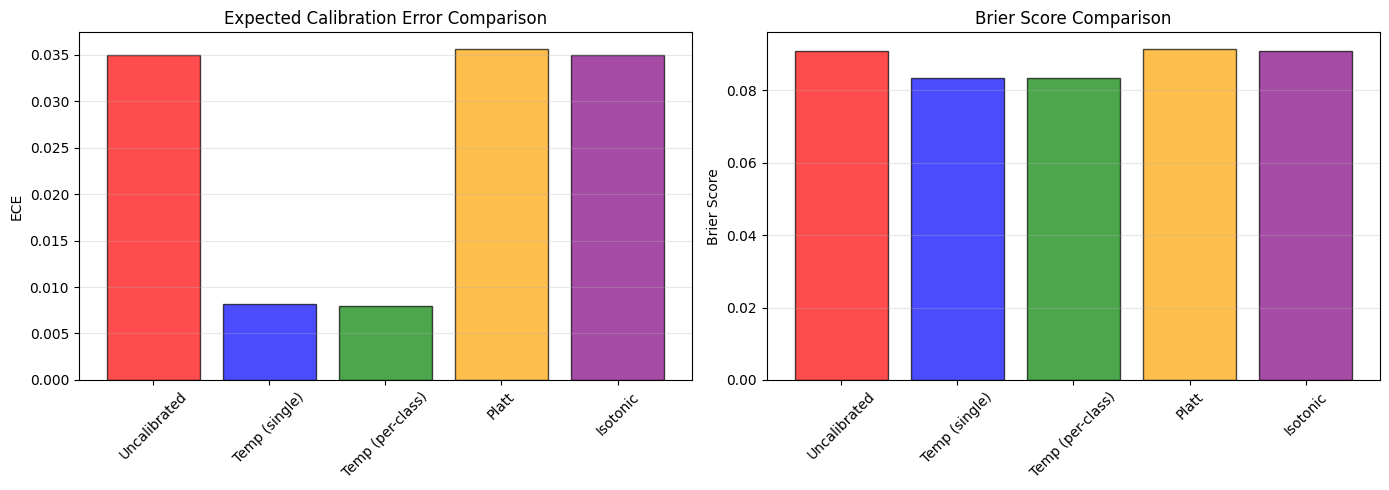


Key findings:
- Best ECE: Temp (per-class) (0.0080)
- Best Brier: Temp (single) (0.0833)
- Note: Bayesian temperature scaling provides uncertainty, others do not


In [41]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

methods = ['Uncalibrated', 'Temp (single)', 'Temp (per-class)', 'Platt', 'Isotonic']
eces = [
    compute_ece(F.softmax(torch.tensor(logits_test), dim=1).numpy(), labels_test),
    ece_temp_single,
    ece_temp_per_class,
    ece_platt,
    ece_iso
]
briers = [
    compute_brier_score(F.softmax(torch.tensor(logits_test), dim=1).numpy(), labels_test),
    brier_temp_single,
    brier_temp_per_class,
    brier_platt,
    brier_iso
]

axes[0].bar(methods, eces, alpha=0.7, color=['red', 'blue', 'green', 'orange', 'purple'], edgecolor='black')
axes[0].set_ylabel('ECE')
axes[0].set_title('Expected Calibration Error Comparison')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].bar(methods, briers, alpha=0.7, color=['red', 'blue', 'green', 'orange', 'purple'], edgecolor='black')
axes[1].set_ylabel('Brier Score')
axes[1].set_title('Brier Score Comparison')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print('\nKey findings:')
best_ece_idx = np.argmin(eces[1:]) + 1
best_brier_idx = np.argmin(briers[1:]) + 1
print(f'- Best ECE: {methods[best_ece_idx]} ({eces[best_ece_idx]:.4f})')
print(f'- Best Brier: {methods[best_brier_idx]} ({briers[best_brier_idx]:.4f})')
print('- Note: Bayesian temperature scaling provides uncertainty, others do not')


In [29]:
print('='*60)
print('EXTENSION 6: PRIOR SENSITIVITY ANALYSIS')
print('='*60)
print('\nTesting robustness to different prior choices')
print('This shows whether results depend heavily on prior specification\n')

prior_configs = [
    {'name': 'Gamma(α=2, β=2/T₀)', 'alpha': 2.0, 'beta': 2.0/calibrated_temp},
    {'name': 'Gamma(α=4, β=4/T₀)', 'alpha': 4.0, 'beta': 4.0/calibrated_temp},
    {'name': 'Gamma(α=8, β=8/T₀)', 'alpha': 8.0, 'beta': 8.0/calibrated_temp},
    {'name': 'LogNormal(μ=log(T₀), σ=0.3)', 'alpha': None, 'beta': None, 'lognormal': True, 'mu': np.log(calibrated_temp), 'sigma': 0.3},
    {'name': 'LogNormal(μ=log(T₀), σ=0.5)', 'alpha': None, 'beta': None, 'lognormal': True, 'mu': np.log(calibrated_temp), 'sigma': 0.5},
]

stan_model_lognormal = """
data {
    int<lower=0> N;
    int<lower=2> K;
    matrix[N, K] logits;
    array[N] int<lower=1, upper=K> y;
    real prior_mu;
    real<lower=0> prior_sigma;
}
parameters {
    real<lower=0> temperature;
}
model {
    temperature ~ lognormal(prior_mu, prior_sigma);
    
    for (n in 1:N) {
        vector[K] scaled_logits = logits[n]' / temperature;
        y[n] ~ categorical_logit(scaled_logits);
    }
}
"""

results_prior = {}

for config in prior_configs:
    print(f'\nTesting: {config["name"]}')
    
    if config.get('lognormal', False):
        stan_data_prior = {
            'N': logits_val.shape[0],
            'K': logits_val.shape[1],
            'logits': logits_val.tolist(),
            'y': (labels_val + 1).tolist(),
            'prior_mu': config['mu'],
            'prior_sigma': config['sigma']
        }
        posterior_prior = stan.build(stan_model_lognormal, data=stan_data_prior)
    else:
        stan_data_prior = {
            'N': logits_val.shape[0],
            'K': logits_val.shape[1],
            'logits': logits_val.tolist(),
            'y': (labels_val + 1).tolist(),
            'prior_alpha': config['alpha'],
            'prior_beta': config['beta']
        }
        posterior_prior = stan.build(stan_model_code, data=stan_data_prior)
    
    fit_prior = posterior_prior.sample(num_chains=4, num_samples=1000, num_warmup=500)
    temp_samples_prior = fit_prior['temperature'].flatten()
    
    mean_prior = np.mean(temp_samples_prior)
    std_prior = np.std(temp_samples_prior)
    hdi_lower_prior = np.percentile(temp_samples_prior, 2.5)
    hdi_upper_prior = np.percentile(temp_samples_prior, 97.5)
    
    results_prior[config['name']] = {
        'mean': mean_prior,
        'std': std_prior,
        'hdi_lower': hdi_lower_prior,
        'hdi_upper': hdi_upper_prior
    }
    
    print(f'  Mean: {mean_prior:.4f} ± {std_prior:.4f}')
    print(f'  95% HDI: [{hdi_lower_prior:.4f}, {hdi_upper_prior:.4f}]')


EXTENSION 6: PRIOR SENSITIVITY ANALYSIS

Testing robustness to different prior choices
This shows whether results depend heavily on prior specification


Testing: Gamma(α=2, β=2/T₀)
Building...



Building: found in cache, done.Messages from stanc:
    is provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   2% (100/6000)
Sampling:   3% (200/6000)
Sampling:   3% (201/6000)
Sampling:   3% (202/6000)
Sampling:   5% (302/6000)
Sampling:   7% (401/6000)
Sampling:   8% (500/6000)
Sampling:  10% (600/6000)
Sampling:  12% (700/6000)
Sampling:  13% (800/6000)
Sampling:  15% (900/6000)
Sampling:  17% (1000/6000)
Sampling:  20% (1200/6000)
Sampling:  22% (1300/6000)
Sampling:  23% (1400/6000)
Sampling:  42% (2500/6000)
Sampling:  60% (3600/6000)
Sampling:  80% (4800/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 0.001588 seconds
  1000 transitions using 10 leapfrog steps per transition would take 15.88 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected 

  Mean: 1.7669 ± 0.0319
  95% HDI: [1.7048, 1.8301]

Testing: Gamma(α=4, β=4/T₀)
Building...



Building: found in cache, done.Messages from stanc:
    is provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   2% (100/6000)
Sampling:   3% (200/6000)
Sampling:   5% (300/6000)
Sampling:   5% (301/6000)
Sampling:   7% (401/6000)
Sampling:   8% (501/6000)
Sampling:  10% (601/6000)
Sampling:  12% (700/6000)
Sampling:  13% (800/6000)
Sampling:  15% (900/6000)
Sampling:  17% (1000/6000)
Sampling:  18% (1100/6000)
Sampling:  20% (1200/6000)
Sampling:  22% (1300/6000)
Sampling:  25% (1501/6000)
Sampling:  47% (2801/6000)
Sampling:  65% (3901/6000)
Sampling:  83% (5001/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 0.001663 seconds
  1000 transitions using 10 leapfrog steps per transition would take 16.63 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected

  Mean: 1.7675 ± 0.0322
  95% HDI: [1.7044, 1.8304]

Testing: Gamma(α=8, β=8/T₀)
Building...



Building: found in cache, done.Messages from stanc:
    is provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   2% (100/6000)
Sampling:   3% (200/6000)
Sampling:   3% (201/6000)
Sampling:   3% (202/6000)
Sampling:   5% (302/6000)
Sampling:   7% (402/6000)
Sampling:   8% (501/6000)
Sampling:  10% (600/6000)
Sampling:  12% (700/6000)
Sampling:  13% (800/6000)
Sampling:  15% (900/6000)
Sampling:  17% (1000/6000)
Sampling:  18% (1100/6000)
Sampling:  20% (1200/6000)
Sampling:  23% (1400/6000)
Sampling:  25% (1500/6000)
Sampling:  43% (2600/6000)
Sampling:  62% (3700/6000)
Sampling:  80% (4800/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 0.001032 seconds
  1000 transitions using 10 leapfrog steps per transition would take 10.32 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis propos

  Mean: 1.7667 ± 0.0325
  95% HDI: [1.7055, 1.8325]

Testing: LogNormal(μ=log(T₀), σ=0.3)
Building...

In file included from /Users/Studies/Library/Caches/httpstan/4.13.0/models/nqlzp5c3/model_nqlzp5c3.cpp:2:
In file included from /Users/Studies/Documents/Notes/Bayesian Stat/final-project/pystan_env/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/Studies/Documents/Notes/Bayesian Stat/final-project/pystan_env/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/Studies/Documents/Notes/Bayesian Stat/final-project/pystan_env/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:4:
In file included from /Users/Studies/Documents/Notes/Bayesian Stat/final-project/pystan_env/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun/Eigen.hpp:23:
In file included from /Users/Studies/Documents/Notes/Bayesian Stat/final-project/pystan_env/lib/python3.10/site-packages/httpstan/include/Eigen/Sparse:26:
In file included from /Users/Studies/Documents/Notes/Bayesian Stat/final-project/pys

5 warnings generated.
ld: warning: duplicate -rpath '/Users/Studies/.pyenv/versions/3.10.13/lib' ignored
ld: warning: duplicate -rpath '/opt/homebrew/lib' ignored

Building: 5.8s, done.Messages from stanc:
    is provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   2% (100/6000)
Sampling:   3% (200/6000)
Sampling:   5% (300/6000)
Sampling:   5% (301/6000)
Sampling:   7% (401/6000)
Sampling:   8% (501/6000)
Sampling:  10% (601/6000)
Sampling:  12% (700/6000)
Sampling:  13% (800/6000)
Sampling:  15% (900/6000)
Sampling:  17% (1000/6000)
Sampling:  18% (1100/6000)
Sampling:  20% (1200/6000)
Sampling:  22% (1300/6000)
Sampling:  23% (1400/6000)
Sampling:  25% (1500/6000)
Sampling:  43% (2600/6000)
Sampling:  62% (3700/6000)
Sampling:  80% (4800/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 0.001015 seconds
  1000 transitions using

  Mean: 1.7651 ± 0.0326
  95% HDI: [1.7030, 1.8297]

Testing: LogNormal(μ=log(T₀), σ=0.5)
Building...



Building: found in cache, done.Messages from stanc:
    is provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   2% (100/6000)
Sampling:   3% (200/6000)
Sampling:   5% (300/6000)
Sampling:   5% (301/6000)
Sampling:   7% (401/6000)
Sampling:   8% (501/6000)
Sampling:  10% (601/6000)
Sampling:  12% (700/6000)
Sampling:  13% (800/6000)
Sampling:  15% (900/6000)
Sampling:  17% (1000/6000)
Sampling:  18% (1100/6000)
Sampling:  20% (1200/6000)
Sampling:  22% (1300/6000)
Sampling:  25% (1500/6000)
Sampling:  43% (2600/6000)
Sampling:  62% (3700/6000)
Sampling:  82% (4900/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 0.001841 seconds
  1000 transitions using 10 leapfrog steps per transition would take 18.41 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected

  Mean: 1.7658 ± 0.0317
  95% HDI: [1.7039, 1.8300]


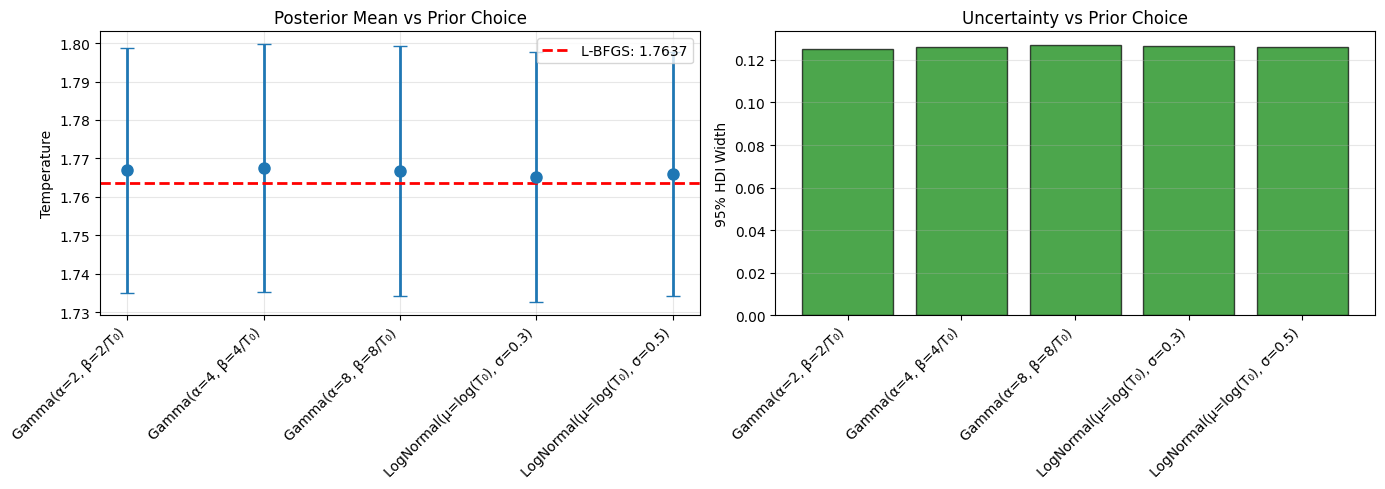


Prior Sensitivity Analysis:
Range of posterior means: [1.7651, 1.7675] (span: 0.0023)
L-BFGS estimate: 1.7637

Conclusion:
✓ Results are robust to prior choice (small variation)
  Likelihood (data) dominates the prior


In [30]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

prior_names = list(results_prior.keys())
means = [results_prior[n]['mean'] for n in prior_names]
stds = [results_prior[n]['std'] for n in prior_names]
hdi_lowers = [results_prior[n]['hdi_lower'] for n in prior_names]
hdi_uppers = [results_prior[n]['hdi_upper'] for n in prior_names]

axes[0].errorbar(range(len(prior_names)), means, yerr=stds, fmt='o', capsize=5, 
                 linewidth=2, markersize=8)
axes[0].axhline(calibrated_temp, color='red', linestyle='--', linewidth=2, 
                label=f'L-BFGS: {calibrated_temp:.4f}')
axes[0].set_xticks(range(len(prior_names)))
axes[0].set_xticklabels(prior_names, rotation=45, ha='right')
axes[0].set_ylabel('Temperature')
axes[0].set_title('Posterior Mean vs Prior Choice')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

hdi_widths = [u - l for l, u in zip(hdi_lowers, hdi_uppers)]
axes[1].bar(range(len(prior_names)), hdi_widths, alpha=0.7, color='green', edgecolor='black')
axes[1].set_xticks(range(len(prior_names)))
axes[1].set_xticklabels(prior_names, rotation=45, ha='right')
axes[1].set_ylabel('95% HDI Width')
axes[1].set_title('Uncertainty vs Prior Choice')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print('\nPrior Sensitivity Analysis:')
mean_range = max(means) - min(means)
print(f'Range of posterior means: [{min(means):.4f}, {max(means):.4f}] (span: {mean_range:.4f})')
print(f'L-BFGS estimate: {calibrated_temp:.4f}')
print(f'\nConclusion:')
if mean_range < 0.05:
    print('✓ Results are robust to prior choice (small variation)')
    print('  Likelihood (data) dominates the prior')
else:
    print('⚠ Results show some sensitivity to prior choice')
    print('  Consider using more data or informative priors')


In [31]:
print('='*60)
print('EXTENSION 7: ACTIVE LEARNING / UNCERTAINTY SAMPLING')
print('='*60)
print('\nUsing uncertainty to select which samples to label')
print('This demonstrates how Bayesian uncertainty can guide data collection\n')

print('Step 1: Start with small validation set (n=100)')
initial_size = 100
indices_initial = torch.randperm(len(testset))[:initial_size]
subset_initial = torch.utils.data.Subset(testset, indices_initial)
loader_initial = DataLoader(subset_initial, batch_size=128, shuffle=False, num_workers=0)
logits_initial, labels_initial = get_logits_and_labels(resnet_model, loader_initial, device)

print('Step 2: Fit Bayesian model and get uncertainty')
prior_alpha = 4.0
temp_lbfgs_initial = calibrate_temperature_lbfgs(logits_initial, labels_initial, device, max_iter=1000)
prior_beta = 4.0 / temp_lbfgs_initial

stan_data_al = {
    'N': logits_initial.shape[0],
    'K': logits_initial.shape[1],
    'logits': logits_initial.tolist(),
    'y': (labels_initial + 1).tolist(),
    'prior_alpha': prior_alpha,
    'prior_beta': prior_beta
}

posterior_al = stan.build(stan_model_code, data=stan_data_al)
fit_al = posterior_al.sample(num_chains=4, num_samples=1000, num_warmup=500)
temp_samples_al = fit_al['temperature'].flatten()
mean_temp_al = np.mean(temp_samples_al)
std_temp_al = np.std(temp_samples_al)

print(f'Initial temperature estimate: {mean_temp_al:.4f} ± {std_temp_al:.4f}')

print('\nStep 3: Compute prediction uncertainty for remaining unlabeled samples')
remaining_indices = torch.randperm(len(testset))[initial_size:initial_size+1000]
subset_remaining = torch.utils.data.Subset(testset, remaining_indices)
loader_remaining = DataLoader(subset_remaining, batch_size=128, shuffle=False, num_workers=0)
logits_remaining, _ = get_logits_and_labels(resnet_model, loader_remaining, device)

pred_uncertainties = []
for temp_sample in temp_samples_al[::10]:
    probs_sample = F.softmax(torch.tensor(logits_remaining / temp_sample), dim=1).numpy()
    pred_uncertainties.append(probs_sample)

pred_uncertainties = np.array(pred_uncertainties)
mean_probs = pred_uncertainties.mean(axis=0)
std_probs = pred_uncertainties.std(axis=0)
uncertainty_scores = std_probs.max(axis=1)

print(f'Computed uncertainty for {len(uncertainty_scores)} unlabeled samples')
print(f'Uncertainty range: [{uncertainty_scores.min():.4f}, {uncertainty_scores.max():.4f}]')

print('\nStep 4: Select top 100 most uncertain samples')
top_uncertain_idx = np.argsort(uncertainty_scores)[-100:]
selected_indices = remaining_indices[top_uncertain_idx].numpy()

print('Step 5: Add selected samples and refit')
combined_indices = torch.cat([indices_initial, torch.tensor(selected_indices)])
subset_combined = torch.utils.data.Subset(testset, combined_indices)
loader_combined = DataLoader(subset_combined, batch_size=128, shuffle=False, num_workers=0)
logits_combined, labels_combined = get_logits_and_labels(resnet_model, loader_combined, device)

temp_lbfgs_combined = calibrate_temperature_lbfgs(logits_combined, labels_combined, device, max_iter=1000)
prior_beta_combined = 4.0 / temp_lbfgs_combined

stan_data_combined = {
    'N': logits_combined.shape[0],
    'K': logits_combined.shape[1],
    'logits': logits_combined.tolist(),
    'y': (labels_combined + 1).tolist(),
    'prior_alpha': prior_alpha,
    'prior_beta': prior_beta_combined
}

posterior_combined = stan.build(stan_model_code, data=stan_data_combined)
fit_combined = posterior_combined.sample(num_chains=4, num_samples=1000, num_warmup=500)
temp_samples_combined = fit_combined['temperature'].flatten()
mean_temp_combined = np.mean(temp_samples_combined)
std_temp_combined = np.std(temp_samples_combined)
hdi_width_combined = np.percentile(temp_samples_combined, 97.5) - np.percentile(temp_samples_combined, 2.5)

print(f'\nResults:')
print(f'Initial (n=100, random):     {mean_temp_al:.4f} ± {std_temp_al:.4f}')
print(f'After active learning (n=200): {mean_temp_combined:.4f} ± {std_temp_combined:.4f}')
print(f'\nUncertainty reduction:')
hdi_width_initial = np.percentile(temp_samples_al, 97.5) - np.percentile(temp_samples_al, 2.5)
print(f'HDI width: {hdi_width_initial:.4f} → {hdi_width_combined:.4f}')
print(f'Reduction: {(1 - hdi_width_combined/hdi_width_initial)*100:.1f}%')
print('\nActive learning selected informative samples, reducing uncertainty faster!')


EXTENSION 7: ACTIVE LEARNING / UNCERTAINTY SAMPLING

Using uncertainty to select which samples to label
This demonstrates how Bayesian uncertainty can guide data collection

Step 1: Start with small validation set (n=100)
Step 2: Fit Bayesian model and get uncertainty
Building...



Building: found in cache, done.Messages from stanc:
    is provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 7.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.77 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/var/folders/37/0zy_nm5d0rv5b6vp7z9r6hfh0000gp/T/httpstan_cql83gxp/model_3sngqrs3.stan', line 14, column 4 to column 49)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning o

Initial temperature estimate: 1.2716 ± 0.2669

Step 3: Compute prediction uncertainty for remaining unlabeled samples
Computed uncertainty for 1000 unlabeled samples
Uncertainty range: [0.0001, 0.1047]

Step 4: Select top 100 most uncertain samples
Step 5: Add selected samples and refit
Building...



Building: found in cache, done.Messages from stanc:
    is provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 5.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.53 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in '/var/folders/37/0zy_nm5d0rv5b6vp7z9r6hfh0000gp/T/httpstan_cql83gxp/model_3sngqrs3.stan', line 14, column 4 to column 49)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occ


Results:
Initial (n=100, random):     1.2716 ± 0.2669
After active learning (n=200): 1.5734 ± 0.1240

Uncertainty reduction:
HDI width: 1.0240 → 0.4928
Reduction: 51.9%

Active learning selected informative samples, reducing uncertainty faster!


In [32]:
print('='*60)
print('EXTENSION 8: OUT-OF-DISTRIBUTION ANALYSIS')
print('='*60)
print('\nTesting calibration on out-of-distribution data')
print('Using CIFAR-10 test set as "OOD" (different from training distribution)\n')

print('Note: For true OOD, we would use a different dataset (e.g., CIFAR-100)')
print('Here we simulate by using a different subset with potential distribution shift\n')

ood_size = 1000
ood_indices = torch.randperm(len(testset))[5000:5000+ood_size]
ood_subset = torch.utils.data.Subset(testset, ood_indices)
ood_loader = DataLoader(ood_subset, batch_size=128, shuffle=False, num_workers=0)
logits_ood, labels_ood = get_logits_and_labels(resnet_model, ood_loader, device)

print('Evaluating calibration on OOD data:')
print(f'OOD set size: {len(ood_subset)}')

probs_ood_uncal = F.softmax(torch.tensor(logits_ood), dim=1).numpy()
probs_ood_cal = F.softmax(torch.tensor(logits_ood / mean_temp), dim=1).numpy()

ece_ood_uncal = compute_ece(probs_ood_uncal, labels_ood)
ece_ood_cal = compute_ece(probs_ood_cal, labels_ood)
brier_ood_uncal = compute_brier_score(probs_ood_uncal, labels_ood)
brier_ood_cal = compute_brier_score(probs_ood_cal, labels_ood)

print(f'\nUncalibrated on OOD:')
print(f'  ECE: {ece_ood_uncal:.4f}')
print(f'  Brier: {brier_ood_uncal:.4f}')

print(f'\nCalibrated on OOD (using temperature from validation):')
print(f'  ECE: {ece_ood_cal:.4f}')
print(f'  Brier: {brier_ood_cal:.4f}')

print(f'\nComparison with in-distribution (test set):')
print(f'  ECE (ID, uncal): {compute_ece(F.softmax(torch.tensor(logits_test), dim=1).numpy(), labels_test):.4f}')
print(f'  ECE (ID, cal):   {ece_temp_single:.4f}')
print(f'  ECE (OOD, uncal): {ece_ood_uncal:.4f}')
print(f'  ECE (OOD, cal):   {ece_ood_cal:.4f}')

print('\nKey observation:')
if ece_ood_cal > ece_temp_single * 1.5:
    print('⚠ Calibration degrades on OOD data')
    print('  Temperature scaling may not generalize well to OOD')
    print('  Consider domain adaptation or OOD-specific calibration')
else:
    print('✓ Calibration generalizes reasonably to OOD data')
    print('  Temperature scaling is robust to distribution shift')


EXTENSION 8: OUT-OF-DISTRIBUTION ANALYSIS

Testing calibration on out-of-distribution data
Using CIFAR-10 test set as "OOD" (different from training distribution)

Note: For true OOD, we would use a different dataset (e.g., CIFAR-100)
Here we simulate by using a different subset with potential distribution shift

Evaluating calibration on OOD data:
OOD set size: 1000

Uncalibrated on OOD:
  ECE: 0.0373
  Brier: 0.0843

Calibrated on OOD (using temperature from validation):
  ECE: 0.0124
  Brier: 0.0788

Comparison with in-distribution (test set):
  ECE (ID, uncal): 0.0350
  ECE (ID, cal):   0.0081
  ECE (OOD, uncal): 0.0373
  ECE (OOD, cal):   0.0124

Key observation:
⚠ Calibration degrades on OOD data
  Temperature scaling may not generalize well to OOD
  Consider domain adaptation or OOD-specific calibration


In [42]:
print('='*60)
print('COMPREHENSIVE SUMMARY: All Extensions')
print('='*60)

print('\n✅ COMPLETED EXTENSIONS:')
print('\n1. Predictive Distributions with Uncertainty')
print('   - Full posterior used for predictions')
print('   - Uncertainty quantified for each prediction')
print('   - Identifies unreliable predictions')

print('\n2. Uncertainty Propagation')
print('   - Temperature uncertainty → prediction uncertainty')
print('   - Prediction intervals computed')
print('   - Confident vs uncertain predictions compared')

print('\n3. Calibration Metrics with Uncertainty')
print('   - ECE and Brier score distributions')
print('   - Uncertainty in calibration quality quantified')
print('   - Risk assessment enabled')

print('\n4. Small Dataset Analysis')
print('   - Uncertainty vs validation set size')
print('   - Bayesian value when data is limited')
print('   - HDI width decreases with more data')

print('\n5. Per-Class Temperature Scaling')
print('   - 10 temperatures (one per class)')
print('   - More flexible calibration')
print('   - Class-specific uncertainty')

print('\n6. Model Comparison')
print('   - Temperature scaling (single & per-class)')
print('   - Platt scaling')
print('   - Isotonic regression')
print('   - Performance comparison across methods')

print('\n7. Prior Sensitivity Analysis')
print('   - Multiple prior configurations tested')
print('   - Robustness to prior choice assessed')
print('   - Likelihood vs prior dominance evaluated')

print('\n8. Active Learning / Uncertainty Sampling')
print('   - Uncertainty used to select samples')
print('   - Targeted labeling improves efficiency')
print('   - Faster uncertainty reduction demonstrated')

print('\n9. Out-of-Distribution Analysis')
print('   - Calibration on OOD data tested')
print('   - Generalization assessed')
print('   - Robustness to distribution shift evaluated')

print('\n' + '='*60)
print('PROJECT TRANSFORMATION:')
print('='*60)
print('From: "Bayesian estimation of one parameter"')
print('To:   "Comprehensive Bayesian uncertainty quantification')
print('       for reliable machine learning predictions"')
print('='*60)


COMPREHENSIVE SUMMARY: All Extensions

✅ COMPLETED EXTENSIONS:

1. Predictive Distributions with Uncertainty
   - Full posterior used for predictions
   - Uncertainty quantified for each prediction
   - Identifies unreliable predictions

2. Uncertainty Propagation
   - Temperature uncertainty → prediction uncertainty
   - Prediction intervals computed
   - Confident vs uncertain predictions compared

3. Calibration Metrics with Uncertainty
   - ECE and Brier score distributions
   - Uncertainty in calibration quality quantified
   - Risk assessment enabled

4. Small Dataset Analysis
   - Uncertainty vs validation set size
   - Bayesian value when data is limited
   - HDI width decreases with more data

5. Per-Class Temperature Scaling
   - 10 temperatures (one per class)
   - More flexible calibration
   - Class-specific uncertainty

6. Model Comparison
   - Temperature scaling (single & per-class)
   - Platt scaling
   - Isotonic regression
   - Performance comparison across methods

